In [1]:
# ONLY RUN ONCE per kernel intialization.
%cd ../

/mnt/fugu/Public/JeremyV/code/hobby/connectome-harmonics


# Correlation between Resting State Networks and connectome harmonics, and how this changes with age.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, precision_recall_curve, mutual_info_score

In [3]:
nets, ages = get_nets_and_ages()
rsns, labels = load_rsns()

# Aggregated across all subjects

This section takes the average connectome graph from across all available subjects, and correlates these connectome harmonics with the resting state networks.

In [4]:
harmonics, eigval = get_harmonics(nets.mean(-1))
harmonics = harmonics.T

scrambled_nets = resample_edges(nets)
scrambled_harmonics, eigval = get_harmonics(scrambled_nets.mean(-1))
scrambled_harmonics = scrambled_harmonics.T

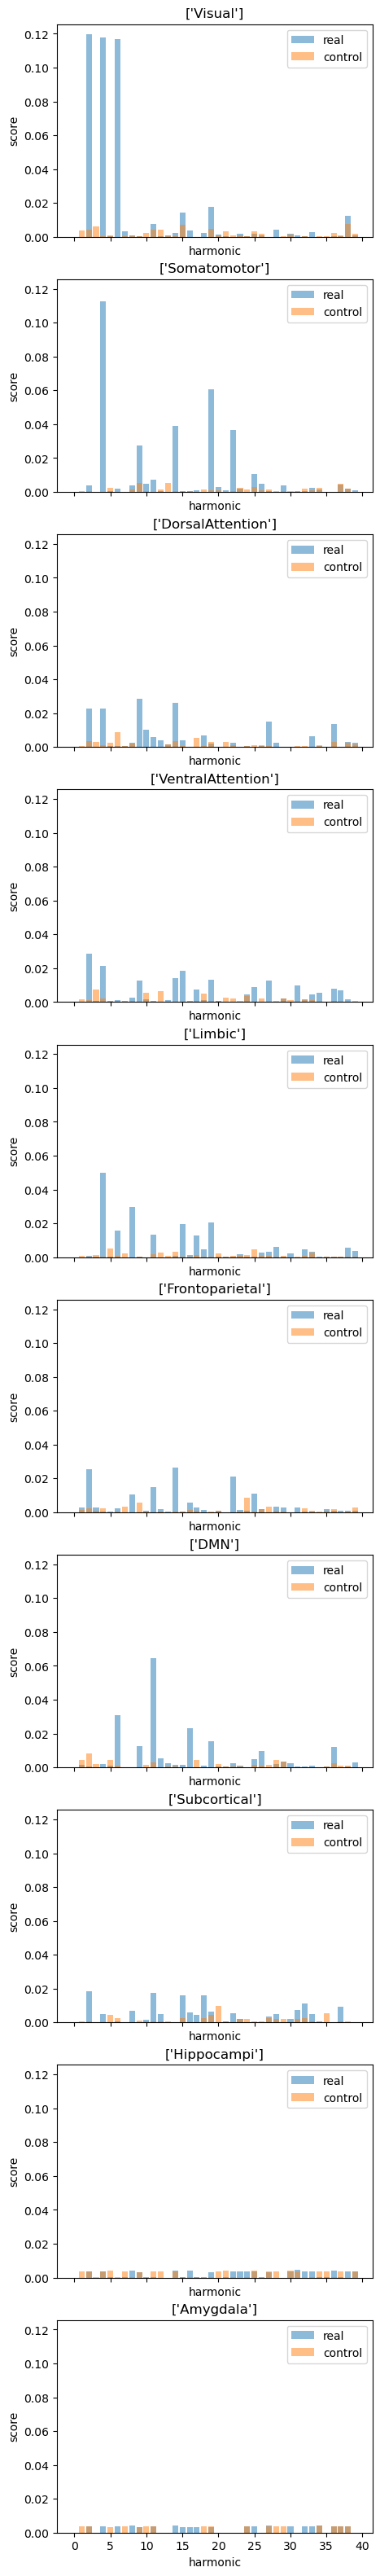

In [26]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(5,40), sharex=True, sharey=True)
for rsn, label, ax in zip(rsns, labels, axs):
    plot_correlations(rsn, harmonics[:40], metric=mutual_information, ax=ax, label='real')
    plot_correlations(rsn, scrambled_harmonics[:40], metric=mutual_information, ax=ax, label='control')
    ax.set_title(label)


# Disaggregated by age group

This section averages the connectomes across 15-year age brackets: 15-29, 30-44, etc. and then for each age group, performs the same analysis as illustrated in the previous section. Each column is an age bracket, each row is an RSN.

15-29: 67
30-44: 143
45-59: 143
60-74: 141
75-89: 100


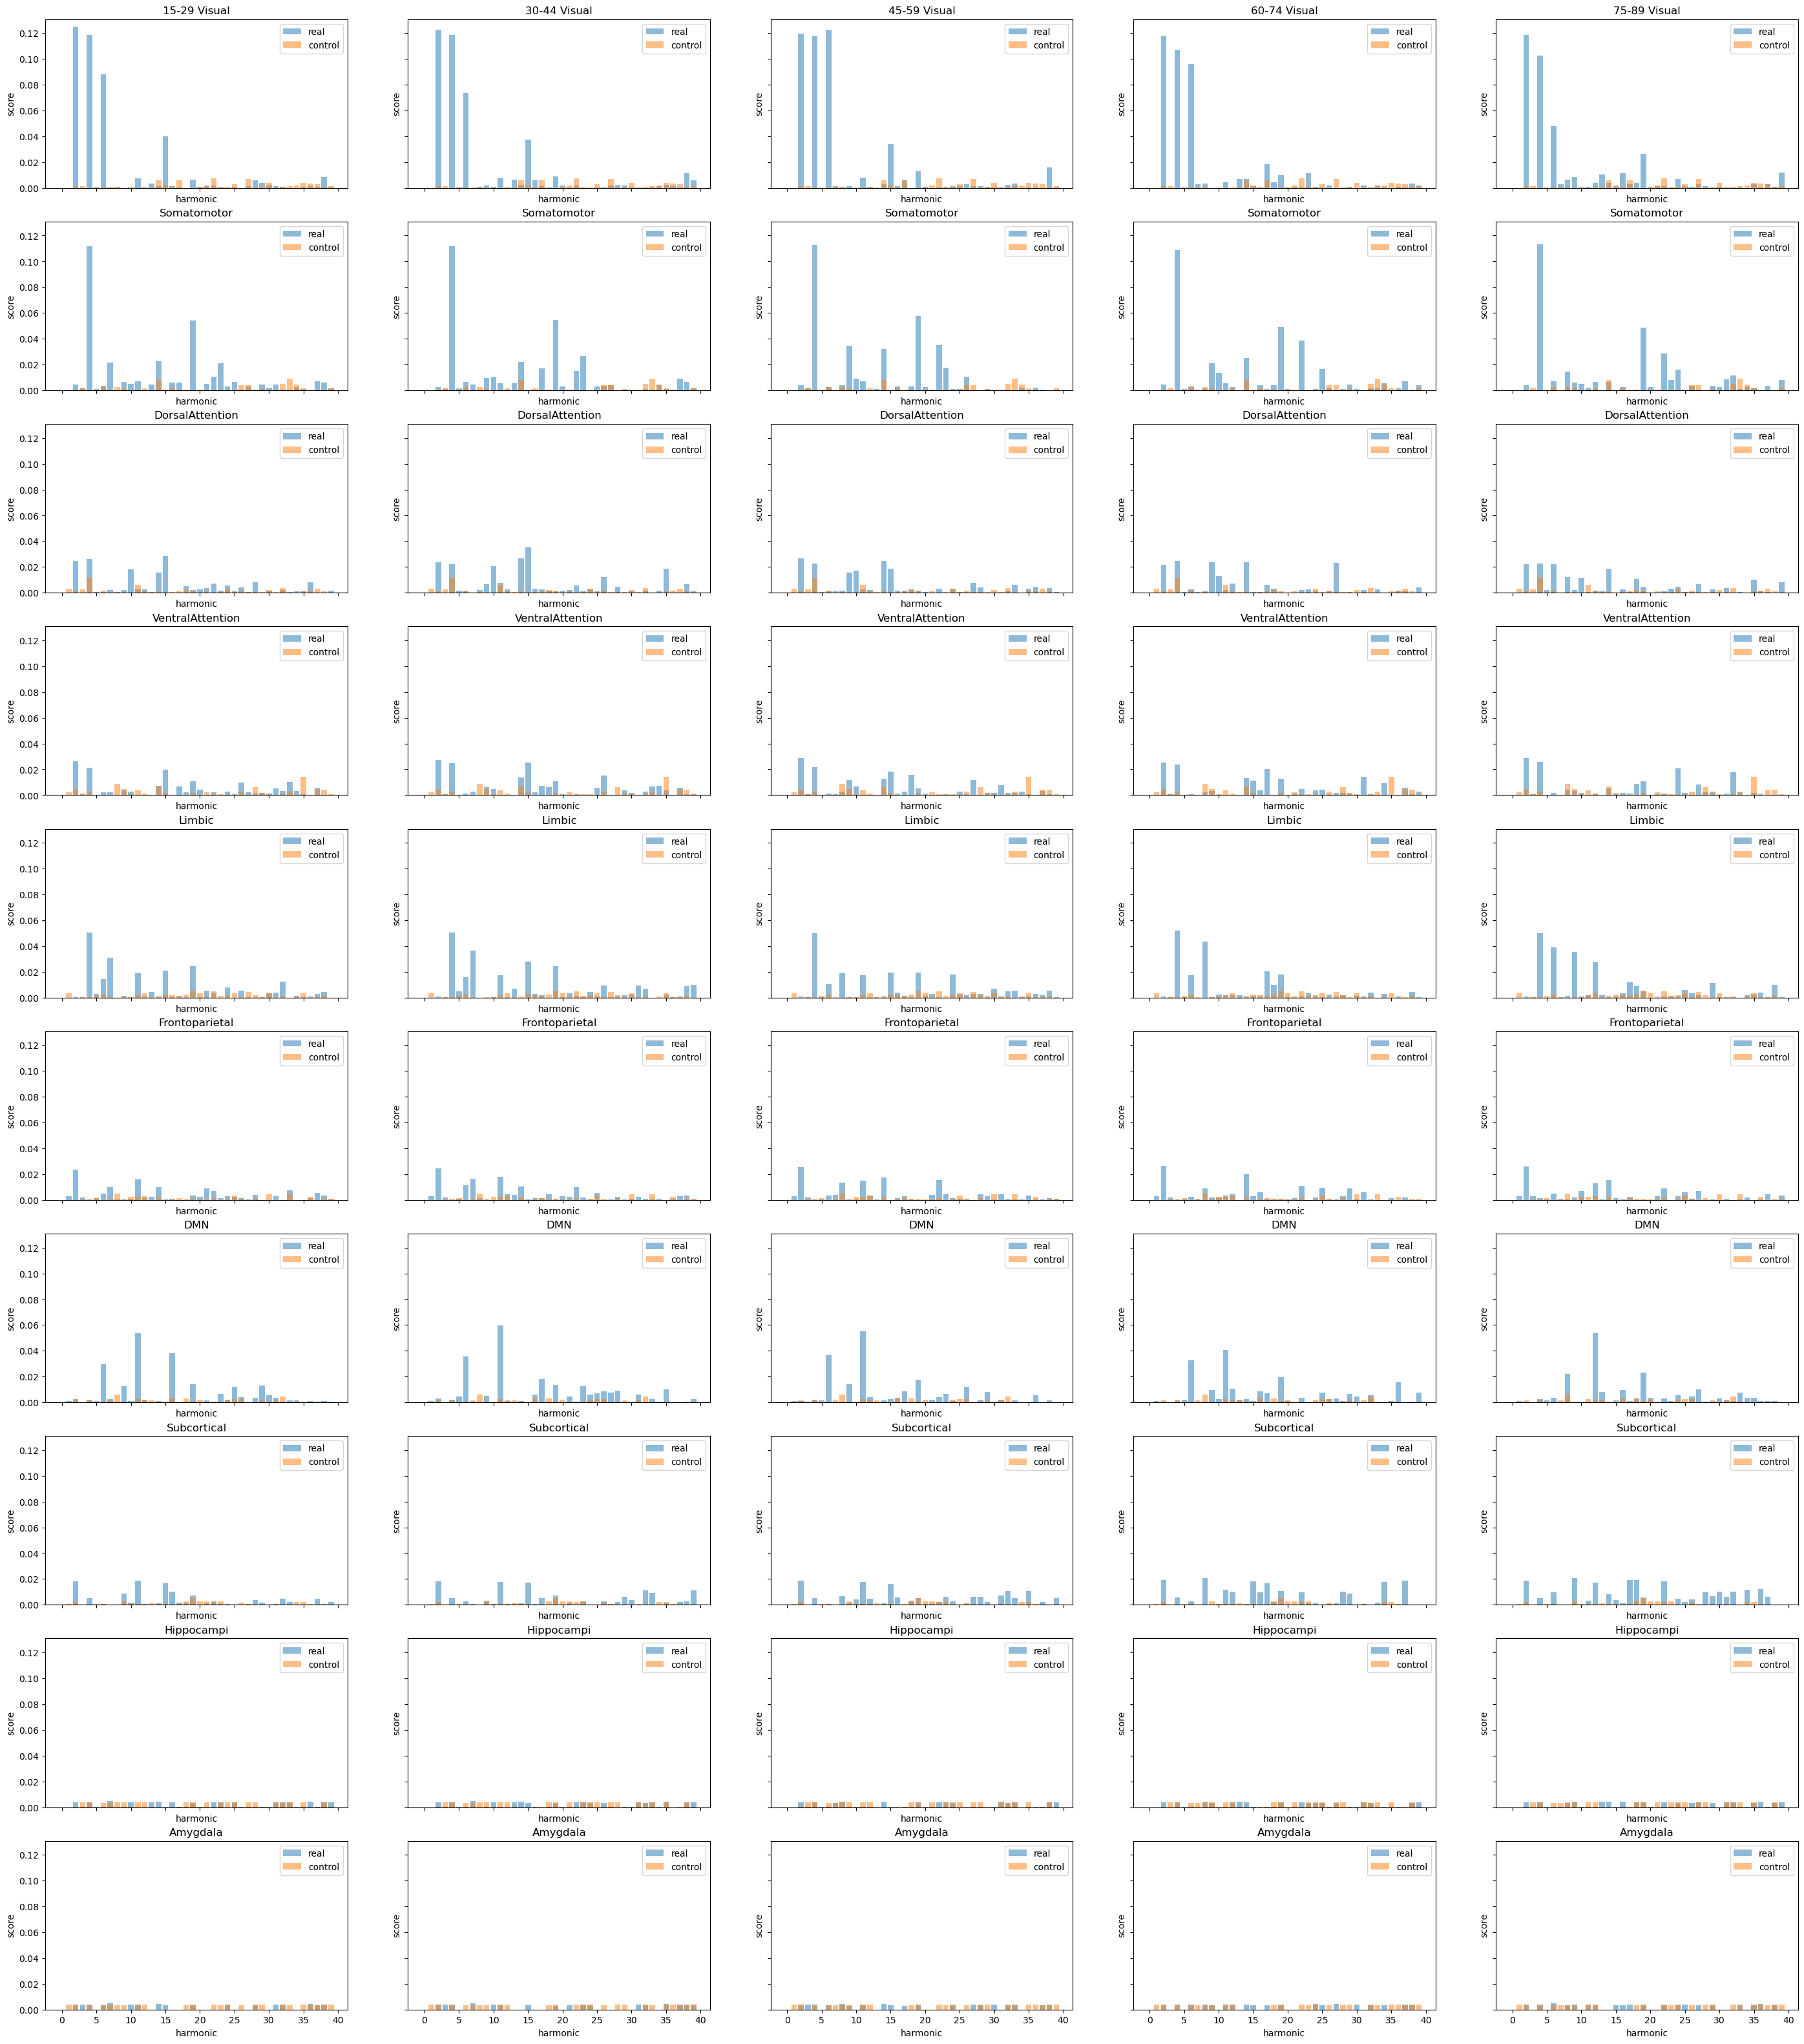

In [14]:
age_brackets = [15, 30, 45, 60, 75]
fig, axs = plt.subplots(nrows=len(labels), ncols=len(age_brackets), figsize=(len(age_brackets)*7, len(labels)*4), sharex=True, sharey=True)
for age_idx, age in enumerate(age_brackets):
    subjects = (ages >= age) & (ages < age+15)
    print(f"{age}-{age+14}: {subjects.sum()}")
    harmonics, eigval = get_harmonics(nets[:,:,subjects].mean(-1))
    harmonics = harmonics.T
    
    for rsn_idx in range(len(rsns)):
        rsn = rsns[rsn_idx]
        label = labels[rsn_idx][0]
        ax = axs[rsn_idx, age_idx]
        plot_correlations(rsn, harmonics[:40], metric=mutual_information, ax=ax, label='real')
        plot_correlations(rsn, scrambled_harmonics[:40], metric=mutual_information, ax=ax, label='control')
        title = label
        if rsn_idx == 0:
            title = f"{age}-{age+14} " + title
        ax.set_title(title)

(array([  0.,   7.,  60.,  94., 103.,  89.,  98.,  94.,  49.,   0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

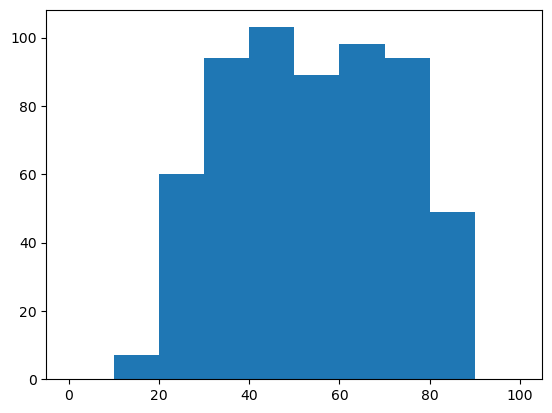

In [8]:
bins = np.linspace(0, 100, 11)
plt.hist(ages, bins=bins)

In [5]:
mat = scipy.io.loadmat("data/nhw2022-network-harmonics-data.mat")
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'age', 'nets', 'None', 'yeoLabs', '__function_workspace__'])

In [6]:
partition, _, labels = mat['yeoLabs'][0][0]
partition = partition[:,0]
labels = labels[0]
rsns = []
for rsn_idx in range(len(labels)):
    rsns.append(partition == rsn_idx + 1)
    
rsns = np.stack(rsns)
rsns.shape

(10, 376)

In [9]:
def find_optimal_threshold(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # Find the F-score for each threshold
    f_scores = (2 * precision * recall) / (precision + recall)
    # Find the index of the threshold that maximizes the F-score
    optimal_idx = np.argmax(f_scores)
    # Find the optimal threshold
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, f_scores.max()

def binary_predictions_from(y_true, y_pred):
    positive_thresh, positive_fscore = find_optimal_threshold(y_true, y_pred)
    negative_thresh, negative_fscore = find_optimal_threshold(y_true, -y_pred)
    
    if positive_fscore > negative_fscore:
        return (y_pred >= positive_thresh).astype(int)
    else:
        return (y_pred >= negative_thresh).astype(int)


def mutual_information(rsn, harmonic):
    return mutual_info_score(rsn, harmonic > 0)

def f_score(rsn,harmonic):
    binary_prediction = binary_predictions_from(rsn, harmonic)
    return f1_score(rsn, binary_prediction)

def plot_correlations(rsn, harmonics, metric, ax=None, label=None):
    scores = []
    for harmonic in harmonics:
        scores.append(metric(rsn, harmonic))
    
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    ax.bar(np.arange(len(harmonics)), scores, label=label, alpha=0.5)
    ax.set_ylabel('score')
    ax.set_xlabel('harmonic')
    ax.legend()

In [8]:
labels[6]

array(['DMN'], dtype='<U3')

In [18]:
h2 = harmonics[:,1,0]
h2_binarized = binary_predictions_from(rsns[0], h2)
h2_binarized

/tmp/ipykernel_7717/4207198737.py:4: RuntimeWarning: invalid value encountered in divide
  f_scores = (2 * precision * recall) / (precision + recall)
/tmp/ipykernel_7717/4207198737.py:4: RuntimeWarning: invalid value encountered in divide
  f_scores = (2 * precision * recall) / (precision + recall)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
mutual_information(rsns[0], h2)

1.3352676935862728e-05